# BASELINE MODELING

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score, make_scorer
from sklearn.pipeline import make_pipeline
from linearmodels.panel import PanelOLS
import statsmodels.api as sm
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

# Import the function from utils.py
# from utils import store_model_performance

In [2]:
df = pd.read_csv('oecd_data_cleaned.csv')

In [3]:
df.head()

country   region  health_exp_pct_gdp continent iso3    year  \
0  Australia  Oceania               6.467   Oceania  AUS  1990.0   
1  Australia  Oceania               6.762   Oceania  AUS  1991.0   
2  Australia  Oceania               6.828   Oceania  AUS  1992.0   
3  Australia  Oceania               6.844   Oceania  AUS  1993.0   
4  Australia  Oceania               6.872   Oceania  AUS  1994.0   

   gdp_per_capita           gdp  gdp_volume_market_prices       cpi  ...  \
0         17838.1  4.136590e+11              8.625100e+11  0.494619  ...   
1         18177.5  4.166640e+11              8.510460e+11  0.510977  ...   
2         19157.7  4.323100e+11              8.767390e+11  0.515928  ...   
3         20184.9  4.552010e+11              9.126430e+11  0.524968  ...   
4         21432.8  4.826680e+11              9.559860e+11  0.535084  ...   

   other_nonproperty_tax_pct_gdp  property_income_pct_gdp  total_expenditure  \
0                          0.884                     1.83       2.613939e+11   
1                          0.884                     2.08       2.613939e+11   
2                          0.884                     2.28       2.613939e+11   
3                          0.884                     2.74       2.613939e+11   
4                          0.660                     1.98       2.613939e+11   

   total_revenue  total_expense_pct_gdp  total_revenue_pct_gdp  \
0   2.273929e+11                 37.928                 42.036   
1   2.273929e+11                 37.928                 42.036   
2   2.273929e+11                 37.928                 42.036   
3   2.273929e+11                 37.928                 42.036   
4   2.124420e+11                 37.928                 44.010   

   public_finance_trait  developing  life_expectancy_outcome_3  \
0                   NaN         0.0                       77.9   
1                   NaN         0.0                       77.9   
2                   NaN         0.0                       77.8   
3                   NaN         0.0                       78.1   
4                   NaN         0.0                       78.4   

   life_expectancy_outcome_5  
0                       77.8  
1                       78.1  
2                       78.4  
3                       78.6  
4                       78.9  

[5 rows x 58 columns]

In [4]:
model_performance = []

# Helper function to store models
def store_model_performance(y_true, y_pred, model_name):
    """
    Function to compute MSE and R-squared for given predictions and actual values,
    and store these metrics in a list of dictionaries.

    Args:
    y_true (array-like): Actual values.
    y_pred (array-like): Predicted values from the model.
    model_name (str): Name of the model.

    Returns:
    None: Appends the performance metrics to the global list 'model_performance'.
    """
    mse = mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    
    performance_dict = {
        'model_name': model_name,
        'mse': mse,
        'r2': r2
    }

    model_performance.append(performance_dict)

# Baseline Model

## Simple Linear Regression

In [5]:
# Simple Linear Regression: 'public_health_exp_pct_gdp' vs 'life_expectancy_outcome_3'

# Removing rows with NaN values in 'public_health_exp_pct_gdp' and 'life_expectancy_outcome_3'
df_cleaned = df.dropna(subset=['public_health_exp_pct_gdp', 'life_expectancy_outcome_3'])

# Preparing the data with the cleaned dataframe
X_cleaned = df_cleaned[['public_health_exp_pct_gdp']].values
y_cleaned = df_cleaned['life_expectancy_outcome_3'].values

# Splitting the data into training and testing sets
X_train_cleaned, X_test_cleaned, y_train_cleaned, y_test_cleaned = train_test_split(X_cleaned, y_cleaned, test_size=0.2, random_state=42)

# Creating and fitting the linear regression model with the cleaned data
lr_model_cleaned = LinearRegression()
lr_model_cleaned.fit(X_train_cleaned, y_train_cleaned)

# Making predictions with the cleaned data
y_pred_cleaned = lr_model_cleaned.predict(X_test_cleaned)

# Calculating metrics for the cleaned data
mse_cleaned = mean_squared_error(y_test_cleaned, y_pred_cleaned)
r2_cleaned = r2_score(y_test_cleaned, y_pred_cleaned)

In [6]:
# Storing model performance using the custom function
store_model_performance(y_test_cleaned, y_pred_cleaned, "Simple Linear Regression")

In [7]:
print(model_performance)

[{'model_name': 'Simple Linear Regression', 'mse': 11.355224581397346, 'r2': 0.13189819250125057}]


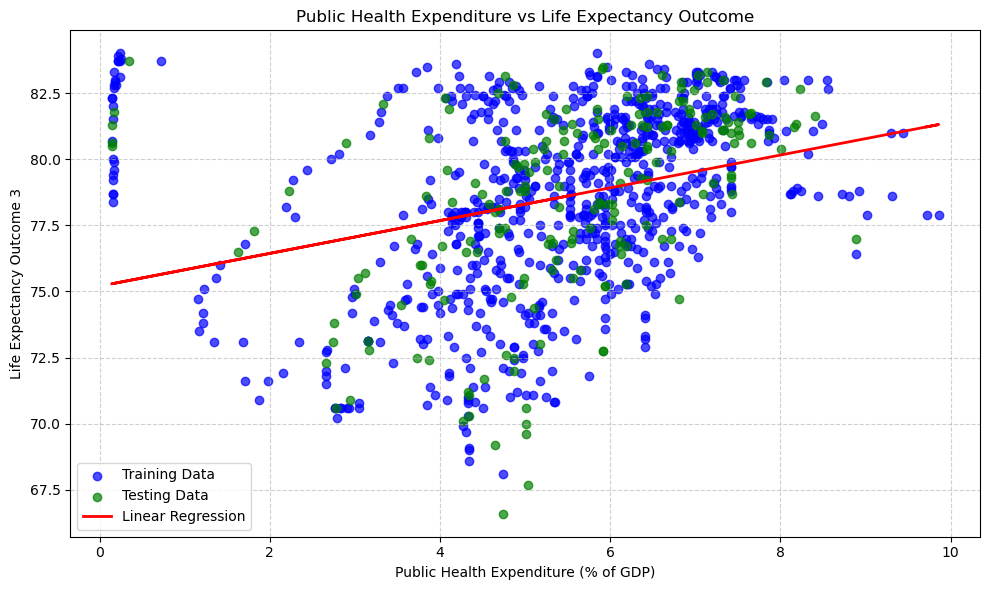

In [8]:
# Set the figure size
plt.figure(figsize=(10, 6))

# Plotting the training data
plt.scatter(X_train_cleaned, y_train_cleaned, color='blue', label='Training Data', alpha=0.7)

# Plotting the testing data
plt.scatter(X_test_cleaned, y_test_cleaned, color='green', label='Testing Data', alpha=0.7)

# Plotting the regression line
line = lr_model_cleaned.coef_[0] * X_cleaned + lr_model_cleaned.intercept_
plt.plot(X_cleaned, line, color='red', label='Linear Regression', linewidth=2)

# Set title and labels
plt.title('Public Health Expenditure vs Life Expectancy Outcome')
plt.xlabel('Public Health Expenditure (% of GDP)')
plt.ylabel('Life Expectancy Outcome 3')

# Add a legend
plt.legend()

# Display the plot
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# Multiple Regression

In [9]:
# Selecting the predictor variables and ensuring there are no NaN values
predictors = ['education_exp_pct_gdp', 
    'wages_exp_pct_gdp', 'pensions_exp_pct_gdp', 'sickness_disability_exp_pct_gdp',
    'unemployment_exp_pct_gdp', 'family_children_exp_pct_gdp', 'subsidies_exp_pct_gdp',
    'social_security_contrib_pct_gdp', 'corporate_income_tax_pct_gdp',
    'environmental_tax_pct_gdp', 'other_consumption_tax_pct_gdp',
    'health_exp_pct_gdp', 'gdp_per_capita']

df_cleaned_multiple = df.dropna(subset=predictors + ['life_expectancy_outcome_3'])

X_multiple = df_cleaned_multiple[predictors].values
y_multiple = df_cleaned_multiple['life_expectancy_outcome_3'].values

# Splitting the data into training and testing sets for the multiple regression model
X_train_multiple, X_test_multiple, y_train_multiple, y_test_multiple = train_test_split(X_multiple, y_multiple, test_size=0.2, random_state=42)

# Creating and fitting the multiple regression model
lr_model_multiple = LinearRegression()
lr_model_multiple.fit(X_train_multiple, y_train_multiple)

# Making predictions with the multiple regression model
y_pred_multiple = lr_model_multiple.predict(X_test_multiple)

# Calculating metrics for the multiple regression model
mse_multiple = mean_squared_error(y_test_multiple, y_pred_multiple)
r2_multiple = r2_score(y_test_multiple, y_pred_multiple)

In [10]:
print(mse_multiple)
print(r2_multiple)

5.417621500321437
0.5858252751356521


In [11]:
# Storing model performance using the custom function
store_model_performance(y_test_multiple, y_pred_multiple, "Multiple Regression")

print(pd.DataFrame(model_performance))

                 model_name        mse        r2
0  Simple Linear Regression  11.355225  0.131898
1       Multiple Regression   5.417622  0.585825


# Polynomial Regression

In [12]:
# Checking if the selected variables are in the dataset
selected_tax_exp_vars = ['education_exp_pct_gdp', 
    'wages_exp_pct_gdp', 'pensions_exp_pct_gdp', 'sickness_disability_exp_pct_gdp',
    'unemployment_exp_pct_gdp', 'family_children_exp_pct_gdp', 'subsidies_exp_pct_gdp',
    'social_security_contrib_pct_gdp', 'corporate_income_tax_pct_gdp',
    'environmental_tax_pct_gdp', 'other_consumption_tax_pct_gdp',
    'health_exp_pct_gdp', 'gdp_per_capita']

# Assuming 'life_expectancy' is the response variable
response_var = 'life_expectancy'

# Check for missing variables in the dataset
missing_vars = [var for var in selected_tax_exp_vars + [response_var] if var not in df.columns]

# If no variables are missing, proceed to prepare the data for polynomial regression
if not missing_vars:
    # Dropping rows with NaN in the selected variables and the response variable
    df_poly = df.dropna(subset=selected_tax_exp_vars + [response_var])

    # Independent variables (tax and expenditure data)
    X_poly = df_poly[selected_tax_exp_vars].values

    # Dependent variable (life expectancy)
    y_poly = df_poly[response_var].values

    # Splitting the data into training and testing sets
    X_train_poly, X_test_poly, y_train_poly, y_test_poly = train_test_split(X_poly, y_poly, test_size=0.2, random_state=42)

    # Creating a polynomial regression model (degree 2 for demonstration)
    poly_reg_model = make_pipeline(PolynomialFeatures(degree=2), LinearRegression())

    # Fitting the model
    poly_reg_model.fit(X_train_poly, y_train_poly)

    # Making predictions
    y_pred_poly = poly_reg_model.predict(X_test_poly)

    # Calculating performance metrics
    mse_poly = mean_squared_error(y_test_poly, y_pred_poly)
    r2_poly = r2_score(y_test_poly, y_pred_poly)

    preparation_status = "Polynomial regression model prepared and evaluated."
else:
    preparation_status = f"Missing variables in the dataset: {missing_vars}"

preparation_status

'Polynomial regression model prepared and evaluated.'

In [13]:
# Storing model performance using the custom function
store_model_performance(y_test_poly, y_pred_poly, "Polynomial Regression (2 degrees)")

In [14]:
model_performance

[{'model_name': 'Simple Linear Regression',
  'mse': 11.355224581397346,
  'r2': 0.13189819250125057},
 {'model_name': 'Multiple Regression',
  'mse': 5.417621500321437,
  'r2': 0.5858252751356521},
 {'model_name': 'Polynomial Regression (2 degrees)',
  'mse': 1.599584802279997,
  'r2': 0.8838227412257361}]

# Polynomial Regression with Cross Validation and Best Degree

## LASSO Regression

##  Ridge Regression

In [15]:
# Checking if the selected variables are in the dataset
selected_tax_exp_vars = ['education_exp_pct_gdp', 
    'wages_exp_pct_gdp', 'pensions_exp_pct_gdp', 'sickness_disability_exp_pct_gdp',
    'unemployment_exp_pct_gdp', 'family_children_exp_pct_gdp', 'subsidies_exp_pct_gdp',
    'social_security_contrib_pct_gdp', 'corporate_income_tax_pct_gdp',
    'environmental_tax_pct_gdp', 'other_consumption_tax_pct_gdp',
    'health_exp_pct_gdp', 'gdp_per_capita']

# Assuming 'life_expectancy' is the response variable
response_var = 'life_expectancy'

# Check for missing variables in the dataset
missing_vars = [var for var in selected_tax_exp_vars + [response_var] if var not in df.columns]

# If no variables are missing, proceed to prepare the data for polynomial regression
if not missing_vars:
    # Dropping rows with NaN in the selected variables and the response variable
    df_poly = df.dropna(subset=selected_tax_exp_vars + [response_var])

    # Independent variables (tax and expenditure data)
    X_poly = df_poly[selected_tax_exp_vars].values

    # Dependent variable (life expectancy)
    y_poly = df_poly[response_var].values

    # Splitting the data into training and testing sets
    X_train_poly, X_test_poly, y_train_poly, y_test_poly = train_test_split(X_poly, y_poly, test_size=0.2, random_state=42)

    # Creating a Ridge Regression model (degree 2 for demonstration)
    ridge_reg_model = make_pipeline(PolynomialFeatures(degree=2), Ridge(alpha=0.01))  # You can adjust the alpha value for regularization strength

    # Fitting the Ridge model
    ridge_reg_model.fit(X_train_poly, y_train_poly)

    # Making predictions with Ridge model
    y_pred_poly_ridge = ridge_reg_model.predict(X_test_poly)

    # Calculating performance metrics for Ridge model
    mse_poly_ridge = mean_squared_error(y_test_poly, y_pred_poly_ridge)
    r2_poly_ridge = r2_score(y_test_poly, y_pred_poly_ridge)

    preparation_status = "Polynomial regression model with Ridge regularization prepared and evaluated."
else:
    preparation_status = f"Missing variables in the dataset: {missing_vars}"

preparation_status

/Users/bryanfores/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:211: LinAlgWarning: Ill-conditioned matrix (rcond=3.92475e-24): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


'Polynomial regression model with Ridge regularization prepared and evaluated.'

In [16]:
# Storing model performance using the custom function
store_model_performance(y_test_poly, y_pred_poly_ridge, "Ridge Regression (2 degrees)")

print(pd.DataFrame(model_performance))

                          model_name        mse        r2
0           Simple Linear Regression  11.355225  0.131898
1                Multiple Regression   5.417622  0.585825
2  Polynomial Regression (2 degrees)   1.599585  0.883823
3       Ridge Regression (2 degrees)   1.598901  0.883872


In [17]:
# best alpha?

## Others

## Random Forest

In [18]:
# Checking if the selected variables are in the dataset
selected_tax_exp_vars = ['education_exp_pct_gdp', 
    'wages_exp_pct_gdp', 'pensions_exp_pct_gdp', 'sickness_disability_exp_pct_gdp',
    'unemployment_exp_pct_gdp', 'family_children_exp_pct_gdp', 'subsidies_exp_pct_gdp',
    'social_security_contrib_pct_gdp', 'corporate_income_tax_pct_gdp',
    'environmental_tax_pct_gdp', 'other_consumption_tax_pct_gdp',
    'health_exp_pct_gdp', 'gdp_per_capita']

# Assuming 'life_expectancy' is the response variable
response_var = 'life_expectancy'


# Dropping rows with NaN in the selected variables and the response variable
df_rf = df.dropna(subset=selected_tax_exp_vars + [response_var])

# Independent variables (tax and expenditure data)
X_rf = df_rf[selected_tax_exp_vars].values

# Dependent variable (life expectancy)
y_rf = df_rf[response_var].values

# Splitting the data into training and testing sets
X_train_rf, X_test_rf, y_train_rf, y_test_rf = train_test_split(X_rf, y_rf, test_size=0.2, random_state=42)

# Number of bootstrap iterations
n_bootstrap = 100  # You can adjust this number based on your needs

# Number of data points in your dataset
n_samples = X_rf.shape[0]

# Initialize an array to store predictions from each bootstrap iteration
bootstrap_predictions = []

# Perform bootstrapping
for _ in range(n_bootstrap):
    # Create a random bootstrap sample with replacement
    indices = np.random.choice(n_samples, size=n_samples, replace=True)
    X_bootstrap = X_rf[indices]
    y_bootstrap = y_rf[indices]

    # Create and train a Random Forest model on the bootstrap sample
    rf_model = RandomForestRegressor(n_estimators=100, random_state=0)
    rf_model.fit(X_bootstrap, y_bootstrap)

    # Make predictions on the test data
    y_pred_rf = rf_model.predict(X_test_rf)

    # Store the predictions
    bootstrap_predictions.append(y_pred_rf)

# Calculate the mean and standard deviation of predictions
mean_predictions = np.mean(bootstrap_predictions, axis=0)
std_predictions = np.std(bootstrap_predictions, axis=0)

# Calculate the Mean Squared Error (MSE) on the aggregated predictions
mse_bootstrapped = mean_squared_error(y_test_rf, mean_predictions)

In [19]:
store_model_performance(y_test_rf, y_pred_rf, "Random Forest")

print(pd.DataFrame(model_performance))

                          model_name        mse        r2
0           Simple Linear Regression  11.355225  0.131898
1                Multiple Regression   5.417622  0.585825
2  Polynomial Regression (2 degrees)   1.599585  0.883823
3       Ridge Regression (2 degrees)   1.598901  0.883872
4                      Random Forest   0.231636  0.983176


# Final Pipeline